In [5]:
import pandas as pd
import glob 
import time
import duckdb

In [6]:
conn = duckdb.connect()

In [7]:
# Manually define the order of schema files
schema_files_order = [
    "dim_seller_locations.sql", 
    "dim_product_categories.sql", 
    "dim_payment_methods.sql", 
    "dim_geography.sql", 
    "dim_demographics.sql", 
    "dim_delivery_status.sql", 
    "dim_brands.sql", 
    "dim_customers.sql", 
    "dim_products.sql", 
    "dim_sellers.sql", 
    "sales_fact.sql"
]

schema_directory = "./schema/"

# Execute each SQL file in the correct order
for sql_file_name in schema_files_order:
    sql_file_path = schema_directory + sql_file_name
    with open(sql_file_path, 'r') as file:
        sql_query = file.read()
    conn.execute(sql_query)

In [8]:
# Define the directory where CSV data is stored
csv_directory = "./olap-table/"

# List of CSV file names corresponding to the schema
csv_files = [
    ("seller_locations.csv", "dim_seller_locations"),
    ("product_categories.csv", "dim_product_categories"),
    ("payment_methods.csv", "dim_payment_methods"),
    ("geography.csv", "dim_geography"),
    ("demographics.csv", "dim_demographics"),
    ("delivery_status.csv", "dim_delivery_status"),
    ("brands.csv", "dim_brands"),
    ("customers.csv", "dim_customers"),
    ("products.csv", "dim_products"),
    ("sellers.csv", "dim_sellers"),
    ("sales_fact.csv", "sales_fact"),
]

# Load data into DuckDB from CSV files
for csv_file, table_name in csv_files:
    csv_path = csv_directory + csv_file
    conn.execute(f"COPY {table_name} FROM '{csv_path}' (DELIMITER ',', HEADER TRUE);")

Sales Performance Analysis

Total Sales by Geography

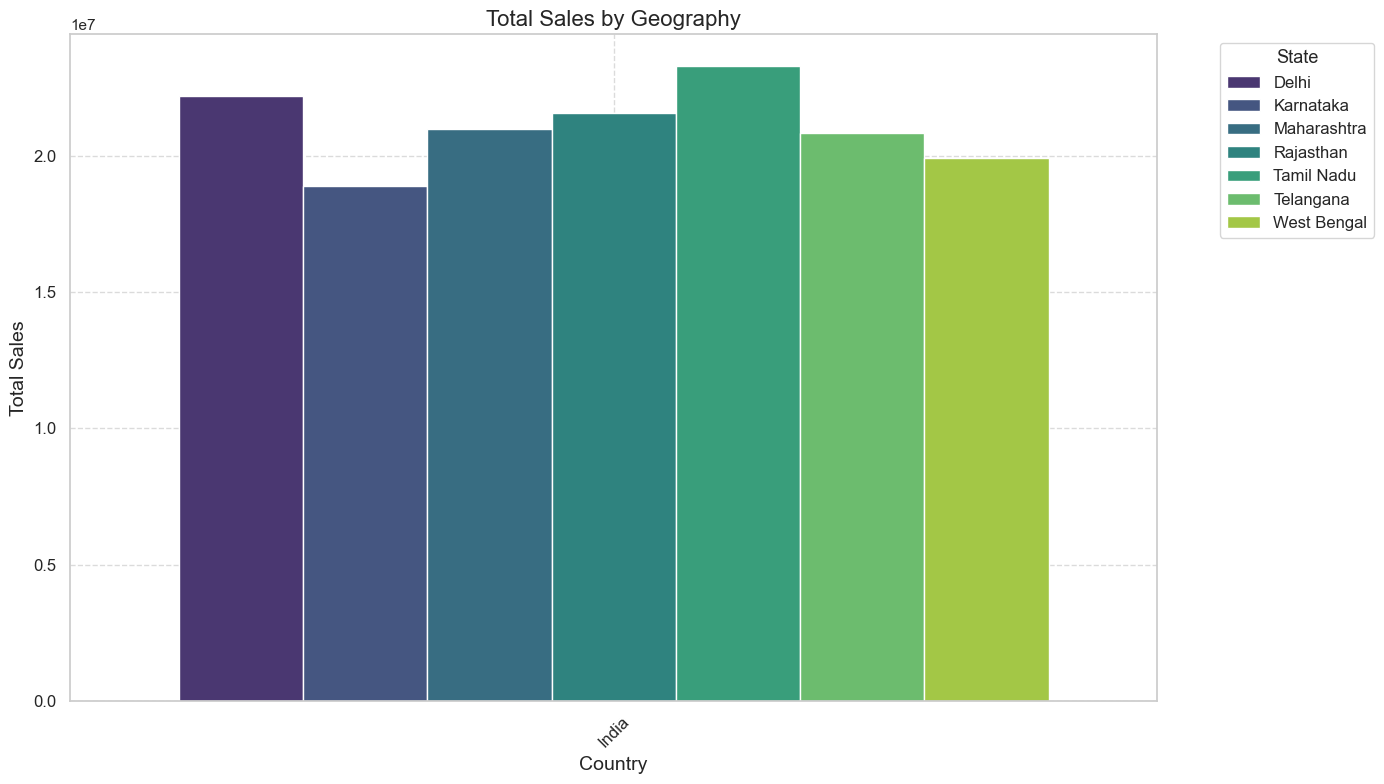

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
sales_data = pd.read_csv('./olap-table/sales_fact.csv')
customers_data = pd.read_csv('./olap-table/customers.csv')
geography_data = pd.read_csv('./olap-table/geography.csv')

# Merge sales data with customers to get Geography_ID
sales_customers_merged = pd.merge(sales_data, customers_data, on='Customer_ID')

# Further merge with geography data
merged_data = pd.merge(sales_customers_merged, geography_data, on='Geography_ID')

# Total sales by geography
total_sales_by_geo = merged_data.groupby(['Country', 'State'])['Total_Amount'].sum().reset_index()

# Plot
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
palette = sns.color_palette("viridis", len(total_sales_by_geo['State'].unique()))
sns.barplot(data=total_sales_by_geo, x='Country', y='Total_Amount', hue='State', palette=palette)

plt.title('Total Sales by Geography', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='State', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Sales Trends Over Time

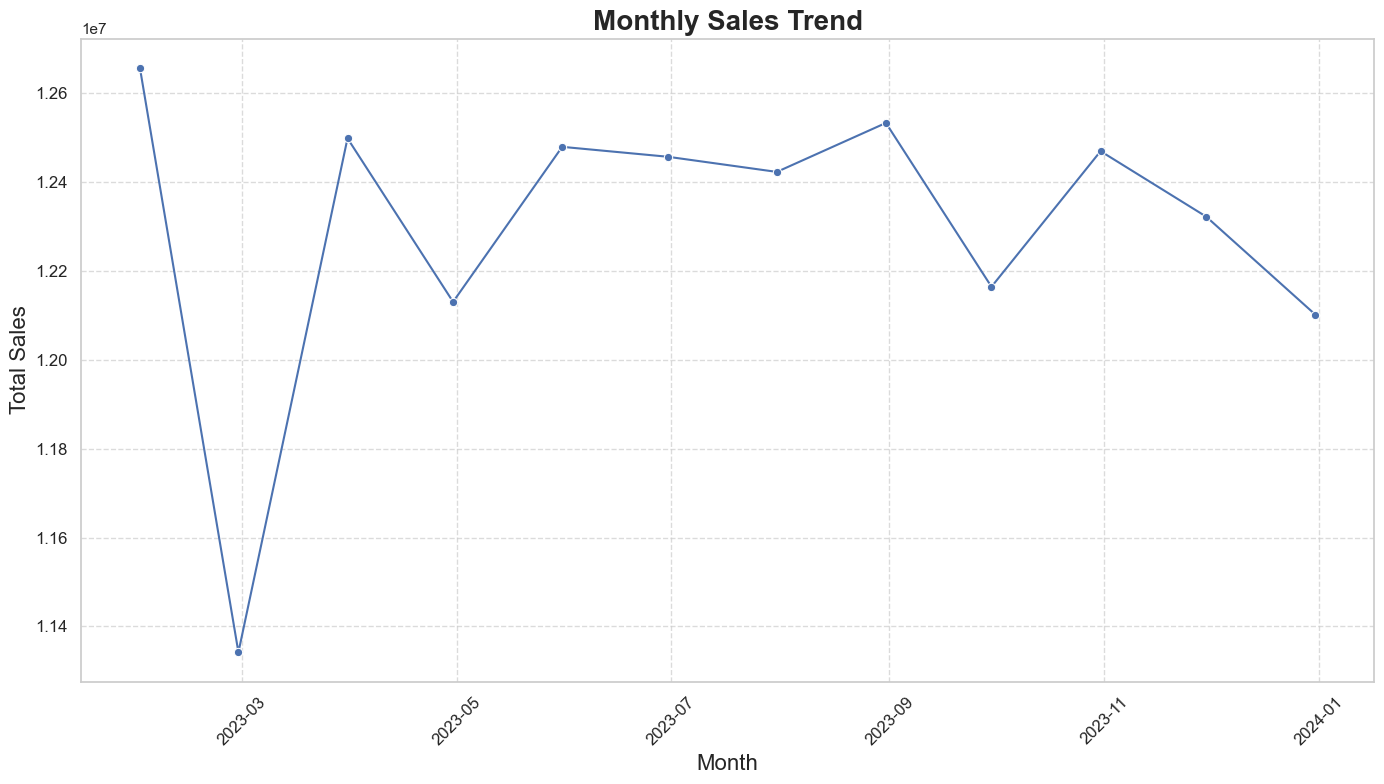

In [82]:
# Convert Order_Date to datetime
sales_data['Order_Date'] = pd.to_datetime(sales_data['Order_Date'])

# Monthly sales trend
monthly_sales = sales_data.resample('M', on='Order_Date')['Total_Amount'].sum().reset_index()

# Plot
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
sns.lineplot(data=monthly_sales, x='Order_Date', y='Total_Amount', marker='o', color='b')

plt.title('Monthly Sales Trend', fontsize=20, fontweight='bold')
plt.xlabel('Month', fontsize=16)
plt.ylabel('Total Sales', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Comparison of Sales Across Different Product Categories

C:\Users\Asus\AppData\Local\Temp\ipykernel_23844\857643788.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  barplot.set_yticklabels(barplot.get_yticks(), fontsize=12)


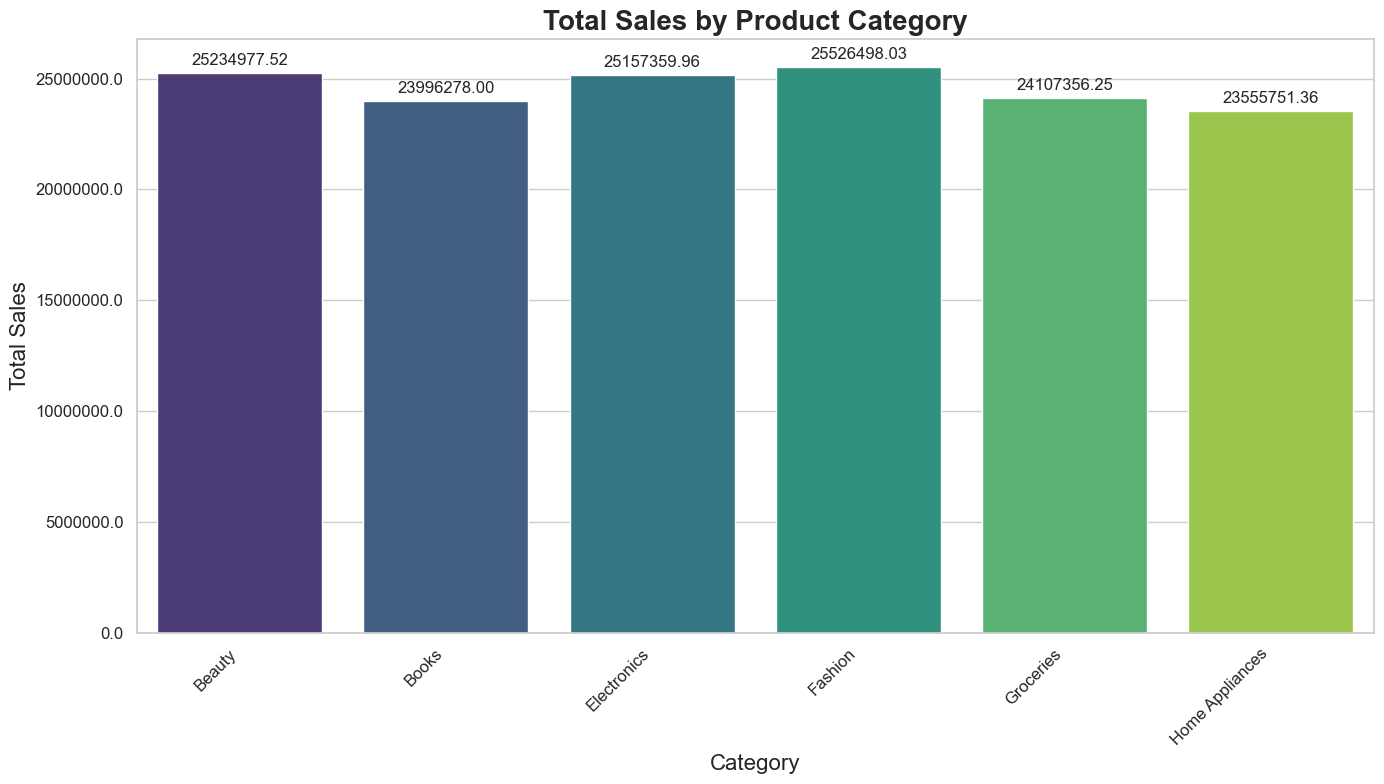

In [83]:
product_data = pd.read_csv('olap-table/products.csv')
category_data = pd.read_csv('olap-table/product_categories.csv')

# Merge data
merged_data = pd.merge(sales_data, product_data, on='Product_ID')
merged_data = pd.merge(merged_data, category_data, on='Category_ID')

# Total sales by category
total_sales_by_category = merged_data.groupby('Category')['Total_Amount'].sum().reset_index()

# Plot
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
palette = sns.color_palette("viridis", len(total_sales_by_category))

barplot = sns.barplot(data=total_sales_by_category, x='Category', y='Total_Amount', palette=palette)
barplot.set_title('Total Sales by Product Category', fontsize=20, fontweight='bold')
barplot.set_xlabel('Category', fontsize=16)
barplot.set_ylabel('Total Sales', fontsize=16)
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
barplot.set_yticklabels(barplot.get_yticks(), fontsize=12)

# Add value labels on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points',
                     fontsize=12)

plt.tight_layout()
plt.show()

Customer Analysis

Demographic Profiles of Top Customers

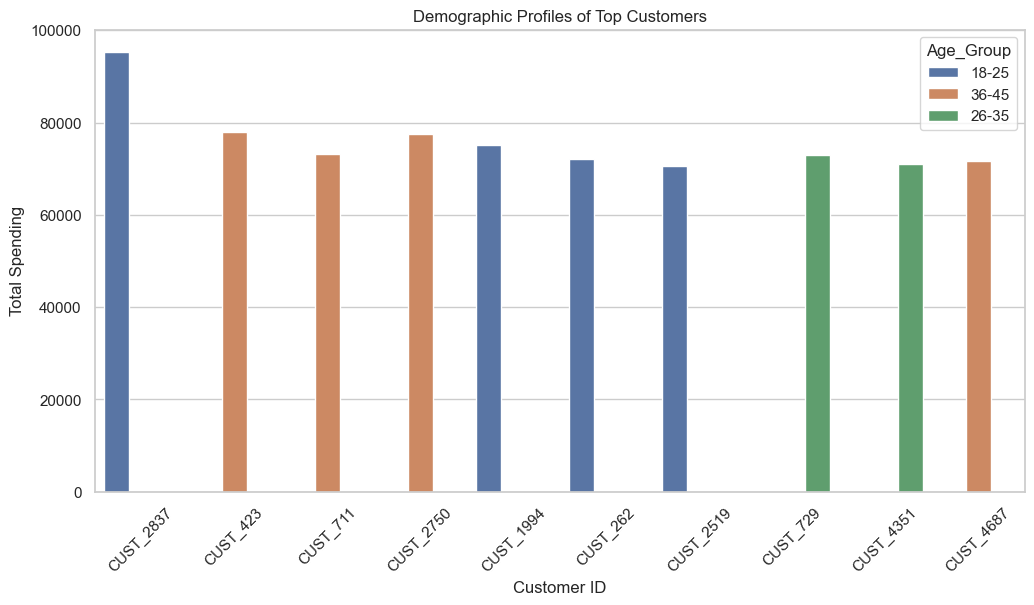

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
sales_data = pd.read_csv('olap-table/sales_fact.csv')
customer_data = pd.read_csv('olap-table/customers.csv')
demographics_data = pd.read_csv('olap-table/demographics.csv')

# Merge data
merged_data = pd.merge(sales_data, customer_data, on='Customer_ID')
merged_data = pd.merge(merged_data, demographics_data, on='Demographics_ID')

#
top_customers = merged_data.groupby(['Customer_ID', 'Demographics_ID'])['Total_Amount'].sum().nlargest(10).reset_index()

# Merge with demographic data
top_customers_demo = pd.merge(top_customers, demographics_data, on='Demographics_ID')

# Plot
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", len(top_customers_demo['Age_Group'].unique()))
barplot = sns.barplot(data=top_customers_demo, x='Customer_ID', y='Total_Amount', hue='Age_Group', palette=palette)

# Add title and labels
barplot.set_title('Demographic Profiles of Top Customers', fontsize=20, fontweight='bold')
barplot.set_xlabel('Customer ID', fontsize=16)
barplot.set_ylabel('Total Spending', fontsize=16)

# Rotate x-axis labels for better readability
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)

# Add value labels on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points',
                     fontsize=12)

# Customize legend
plt.legend(title='Age Group', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


Customer Purchase Patterns

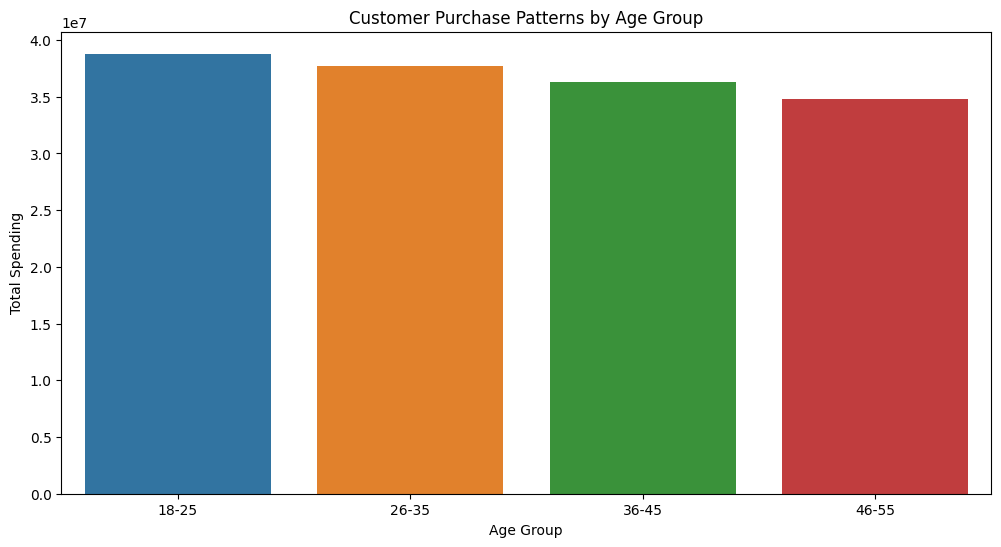

In [17]:
# Purchase patterns by age group
purchase_patterns = merged_data.groupby('Age_Group')['Total_Amount'].sum().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=purchase_patterns, x='Age_Group', y='Total_Amount')
plt.title('Customer Purchase Patterns by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Spending')
plt.show()

Product Analysis

Top Selling Products

C:\Users\Asus\AppData\Local\Temp\ipykernel_23844\3464900839.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=top_selling_products_with_category, x='Product_Name', y='Total_Amount', hue='Category', palette=palette, dodge=False, ci=None)


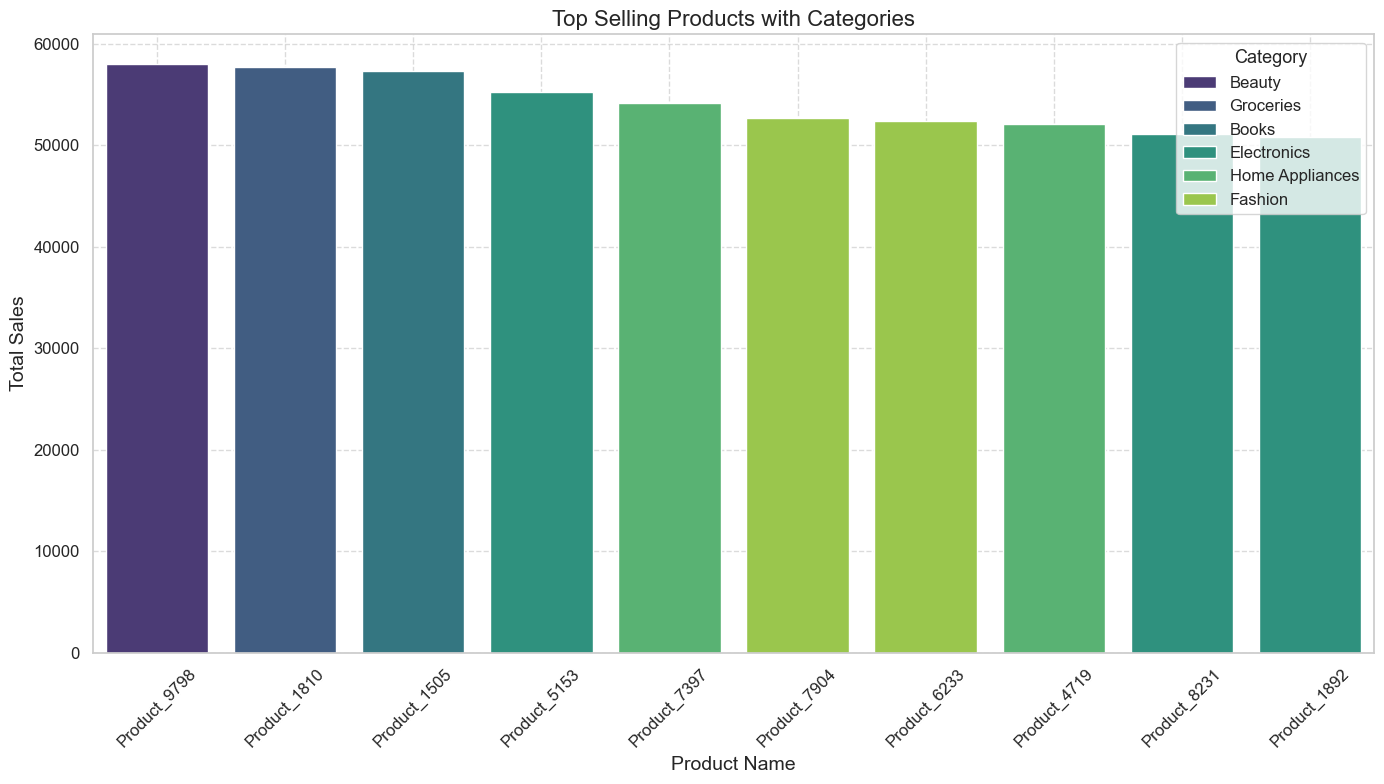

In [46]:
# Merge top selling products with product data to get Category_ID
top_selling_products_with_category_id = pd.merge(top_selling_products, product_data, on='Product_Name')

# Merge with category data to get Category
top_selling_products_with_category = pd.merge(top_selling_products_with_category_id, category_data, on='Category_ID')

# Select relevant columns
top_selling_products_with_category = top_selling_products_with_category[['Product_Name', 'Total_Amount', 'Category']]

# Plot
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
palette = sns.color_palette("viridis", len(top_selling_products_with_category['Category'].unique()))
sns.barplot(data=top_selling_products_with_category, x='Product_Name', y='Total_Amount', hue='Category', palette=palette, dodge=False, ci=None)

plt.title('Top Selling Products with Categories', fontsize=16)
plt.xlabel('Product Name', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Category', title_fontsize='13', fontsize='12')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Product Performance by Region

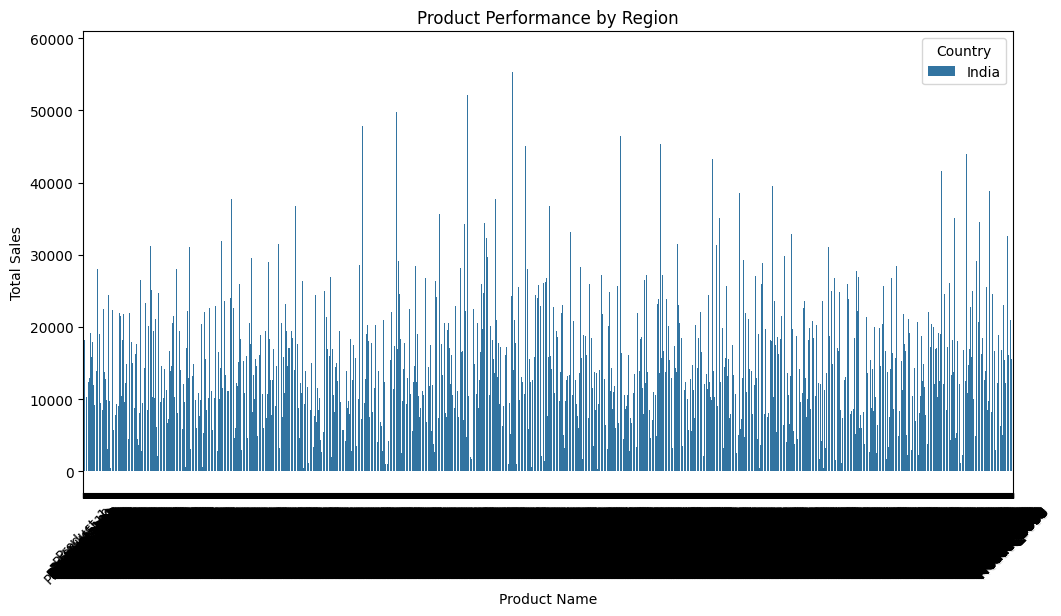

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
sales_data = pd.read_csv('olap-table/sales_fact.csv')
product_data = pd.read_csv('olap-table/products.csv')
customer_data = pd.read_csv('olap-table/customers.csv')
geography_data = pd.read_csv('olap-table/geography.csv')

# Merge sales data with product data
sales_products_merged = pd.merge(sales_data, product_data, on='Product_ID')

# Merge sales and product data with customer data to include Geography_ID
sales_products_customers_merged = pd.merge(sales_products_merged, customer_data, on='Customer_ID')

# Merge further with geography data
sales_products_geo_merged = pd.merge(sales_products_customers_merged, geography_data, on='Geography_ID')

# Product performance by region
product_performance_by_region = sales_products_geo_merged.groupby(['Product_Name', 'Country'])['Total_Amount'].sum().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=product_performance_by_region, x='Product_Name', y='Total_Amount', hue='Country')
plt.title('Product Performance by Region')
plt.xlabel('Product Name')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


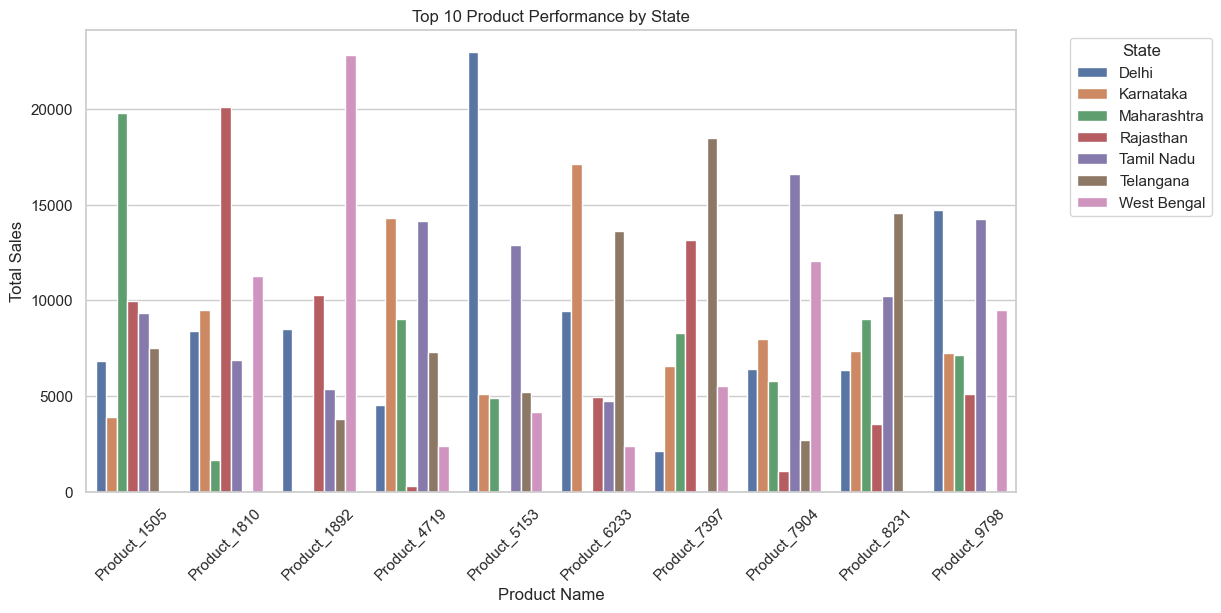

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
sales_data = pd.read_csv('olap-table/sales_fact.csv')
product_data = pd.read_csv('olap-table/products.csv')
customer_data = pd.read_csv('olap-table/customers.csv')
geography_data = pd.read_csv('olap-table/geography.csv')

# Merge sales data with product data
sales_products_merged = pd.merge(sales_data, product_data, on='Product_ID')

# Merge sales and product data with customer data to include Geography_ID
sales_products_customers_merged = pd.merge(sales_products_merged, customer_data, on='Customer_ID')

# Merge further with geography data
sales_products_geo_merged = pd.merge(sales_products_customers_merged, geography_data, on='Geography_ID')

# Product performance by state
product_performance_by_state = sales_products_geo_merged.groupby(['Product_Name', 'State'])['Total_Amount'].sum().reset_index()

# Get top 10 products by total sales
top_products = product_performance_by_state.groupby('Product_Name')['Total_Amount'].sum().nlargest(10).index
top_product_performance = product_performance_by_state[product_performance_by_state['Product_Name'].isin(top_products)]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_product_performance, x='Product_Name', y='Total_Amount', hue='State')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Top 10 Product Performance by State')
plt.xlabel('Product Name')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


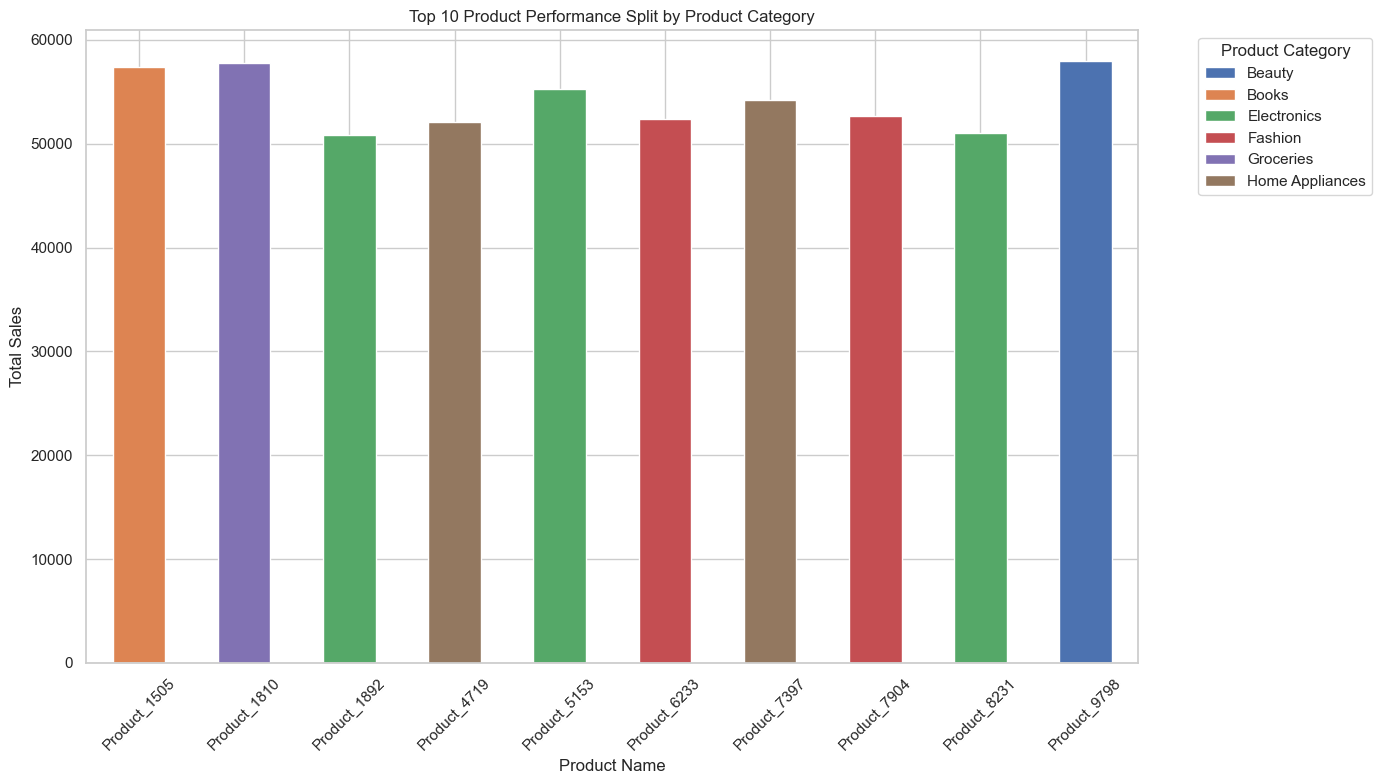

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
sales_data = pd.read_csv('olap-table/sales_fact.csv')
product_data = pd.read_csv('olap-table/products.csv')
product_categories = pd.read_csv('olap-table/product_categories.csv')
customer_data = pd.read_csv('olap-table/customers.csv')
geography_data = pd.read_csv('olap-table/geography.csv')

# Merge operations to bring all necessary data together
sales_products_merged = pd.merge(sales_data, product_data, on='Product_ID')
sales_products_categories_merged = pd.merge(sales_products_merged, product_categories, on='Category_ID')
sales_products_customers_merged = pd.merge(sales_products_categories_merged, customer_data, on='Customer_ID')
sales_products_geo_merged = pd.merge(sales_products_customers_merged, geography_data, on='Geography_ID')

# Product performance by category (aggregating all states)
product_performance_by_category = sales_products_geo_merged.groupby(['Product_Name', 'Category'])['Total_Amount'].sum().reset_index()

# Get top 10 products by total sales across all categories
top_products = product_performance_by_category.groupby('Product_Name')['Total_Amount'].sum().nlargest(10).index
top_product_performance = product_performance_by_category[product_performance_by_category['Product_Name'].isin(top_products)]

# Prepare data for stacked bar chart
pivot_df = top_product_performance.pivot(index='Product_Name', columns='Category', values='Total_Amount')
pivot_df = pivot_df.fillna(0)  # Fill missing values with 0

# Plot stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Top 10 Product Performance Split by Product Category')
plt.xlabel('Product Name')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Seller Performance

Sales by Seller

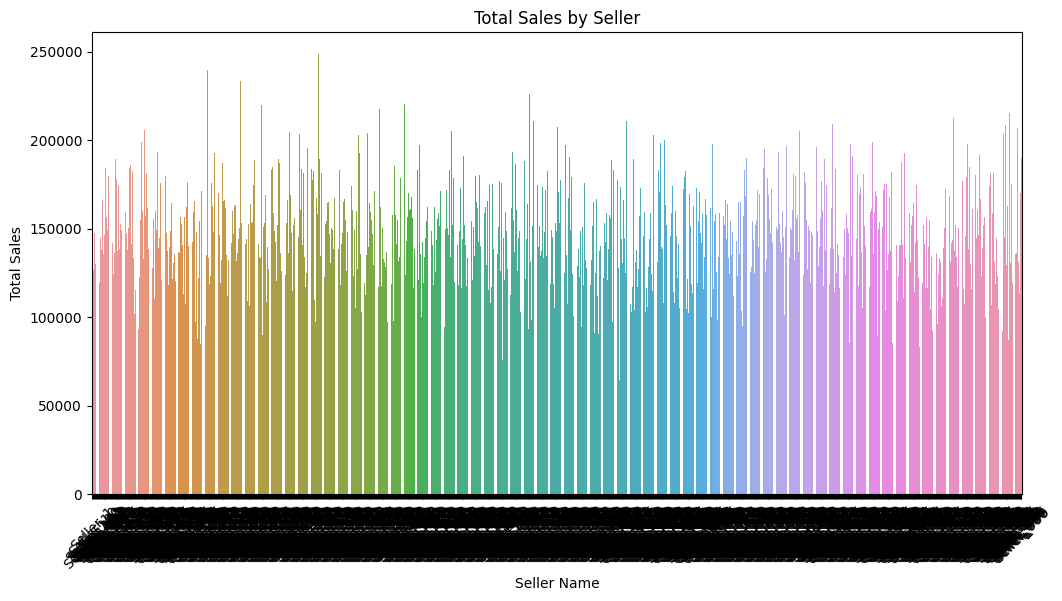

In [20]:
seller_data = pd.read_csv('olap-table/sellers.csv')

# Merge data
merged_data = pd.merge(sales_data, seller_data, on='Seller_ID')

# Total sales by seller
total_sales_by_seller = merged_data.groupby('Seller_Name')['Total_Amount'].sum().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=total_sales_by_seller, x='Seller_Name', y='Total_Amount')
plt.title('Total Sales by Seller')
plt.xlabel('Seller Name')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

In [61]:
print(product_categories.columns)

Index(['Category', 'Subcategory', 'Category_ID'], dtype='object')


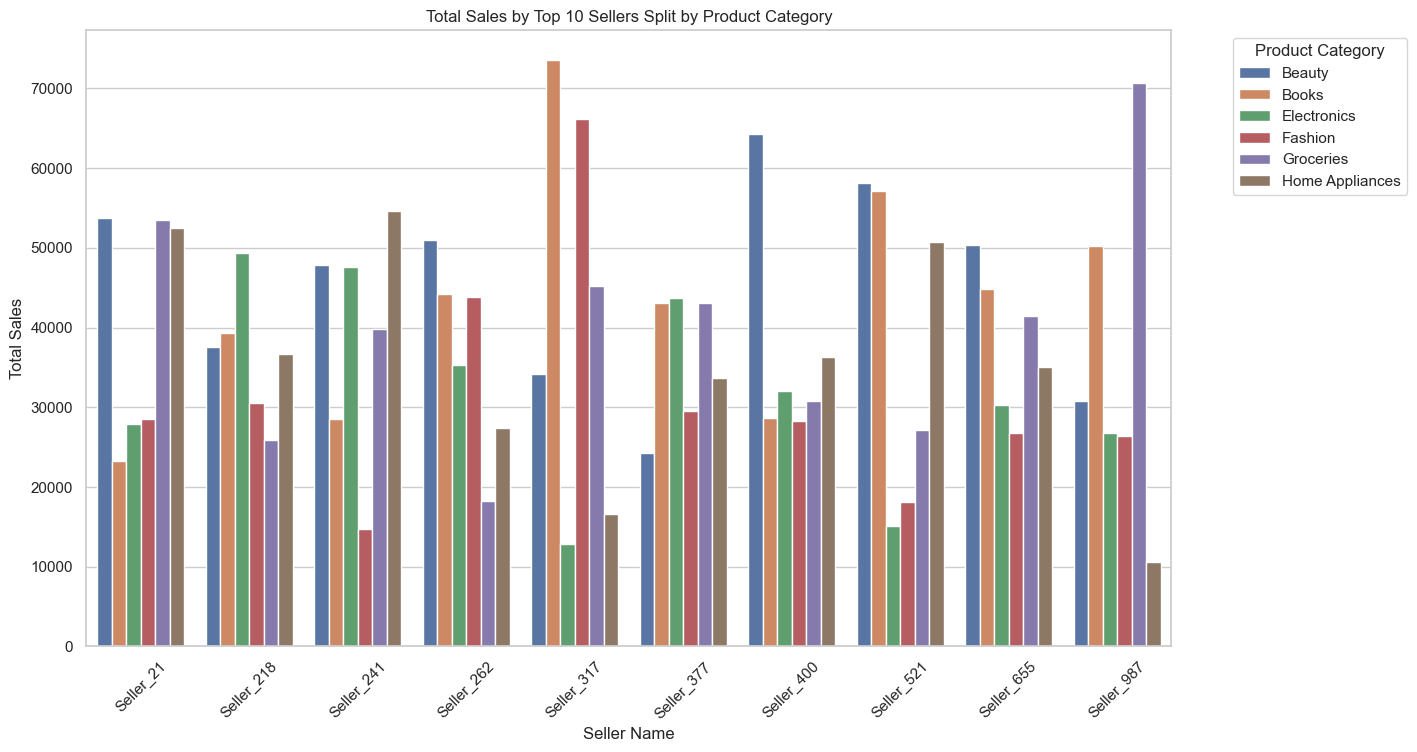

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load necessary data
sales_data = pd.read_csv('olap-table/sales_fact.csv')
seller_data = pd.read_csv('olap-table/sellers.csv')
product_data = pd.read_csv('olap-table/products.csv')
product_categories = pd.read_csv('olap-table/product_categories.csv')

# Ensure data types are correct (if datetime conversion is needed, for example)
# Assuming Product_ID and Category_ID columns are correctly named and present
sales_data['Order_Date'] = pd.to_datetime(sales_data['Order_Date'])

# Merge operations to bring all necessary data together
sales_with_sellers = pd.merge(sales_data, seller_data, on='Seller_ID')
sales_with_products = pd.merge(sales_with_sellers, product_data, on='Product_ID')
merged_data = pd.merge(sales_with_products, product_categories, on='Category_ID')

# Group by Seller and Category, then sum up Total_Amount
grouped_data = merged_data.groupby(['Seller_Name', 'Category'])['Total_Amount'].sum().reset_index()

# Find the top 10 sellers by total sales
top_sellers_total = grouped_data.groupby('Seller_Name')['Total_Amount'].sum().nlargest(10).reset_index()
top_sellers = grouped_data[grouped_data['Seller_Name'].isin(top_sellers_total['Seller_Name'])]

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(data=top_sellers, x='Seller_Name', y='Total_Amount', hue='Category')
plt.title('Total Sales by Top 10 Sellers Split by Product Category')
plt.xlabel('Seller Name')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.legend(title='Product Category')
plt.show()


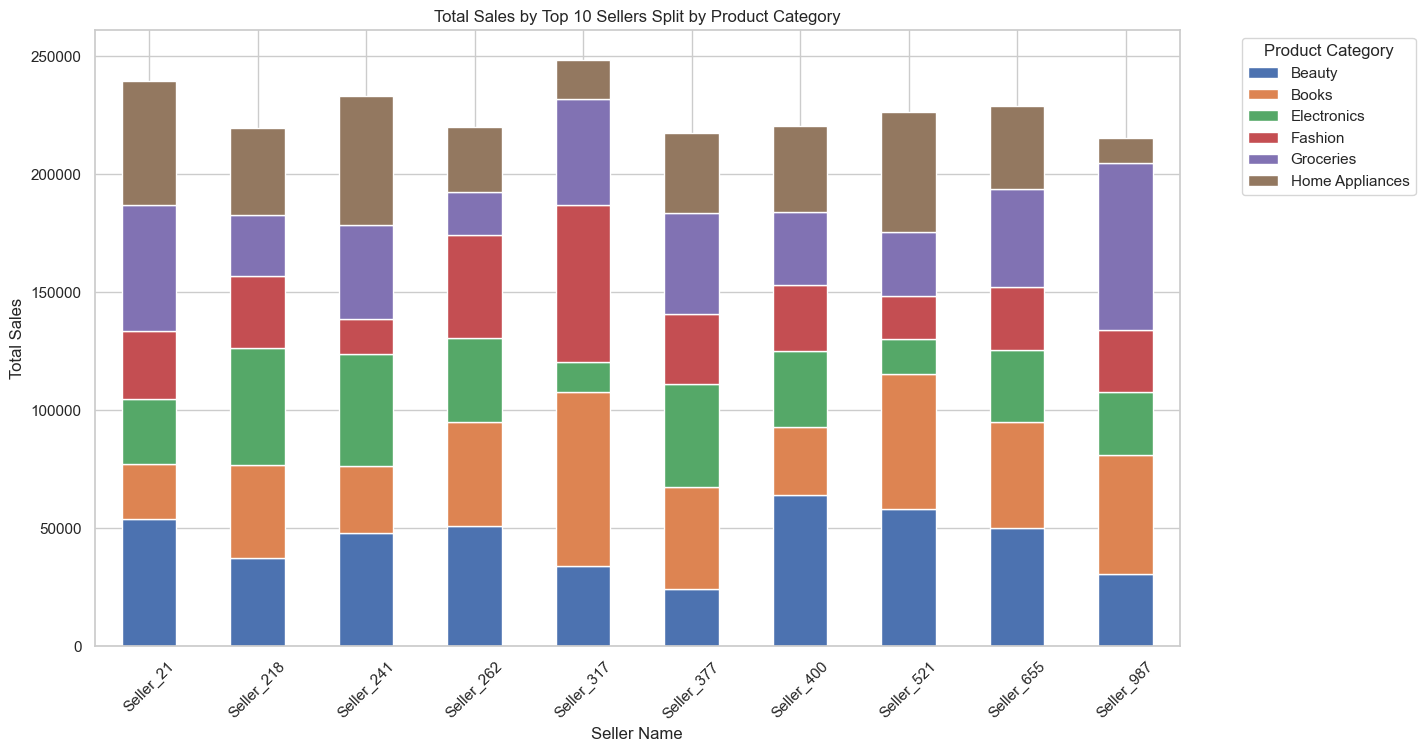

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load necessary data
sales_data = pd.read_csv('olap-table/sales_fact.csv')
seller_data = pd.read_csv('olap-table/sellers.csv')
product_data = pd.read_csv('olap-table/products.csv')
product_categories = pd.read_csv('olap-table/product_categories.csv')

# Assuming Product_ID and Category_ID columns are correctly named and present
sales_data['Order_Date'] = pd.to_datetime(sales_data['Order_Date'])

# Merge operations to bring all necessary data together
sales_with_sellers = pd.merge(sales_data, seller_data, on='Seller_ID')
sales_with_products = pd.merge(sales_with_sellers, product_data, on='Product_ID')
merged_data = pd.merge(sales_with_products, product_categories, on='Category_ID')

# Group by Seller and Category, then sum up Total_Amount
grouped_data = merged_data.groupby(['Seller_Name', 'Category'])['Total_Amount'].sum().reset_index()

# Find the top 10 sellers by total sales
top_sellers_total = grouped_data.groupby('Seller_Name')['Total_Amount'].sum().nlargest(10).reset_index()
top_sellers = grouped_data[grouped_data['Seller_Name'].isin(top_sellers_total['Seller_Name'])]

# Prepare data for stacked bar chart
pivot_df = top_sellers.pivot(index='Seller_Name', columns='Category', values='Total_Amount')
pivot_df = pivot_df.fillna(0)  # Fill missing values with 0

# Plot stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Total Sales by Top 10 Sellers Split by Product Category')
plt.xlabel('Seller Name')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.legend(title='Product Category')
plt.show()


Performance Trends of Sellers Over Time

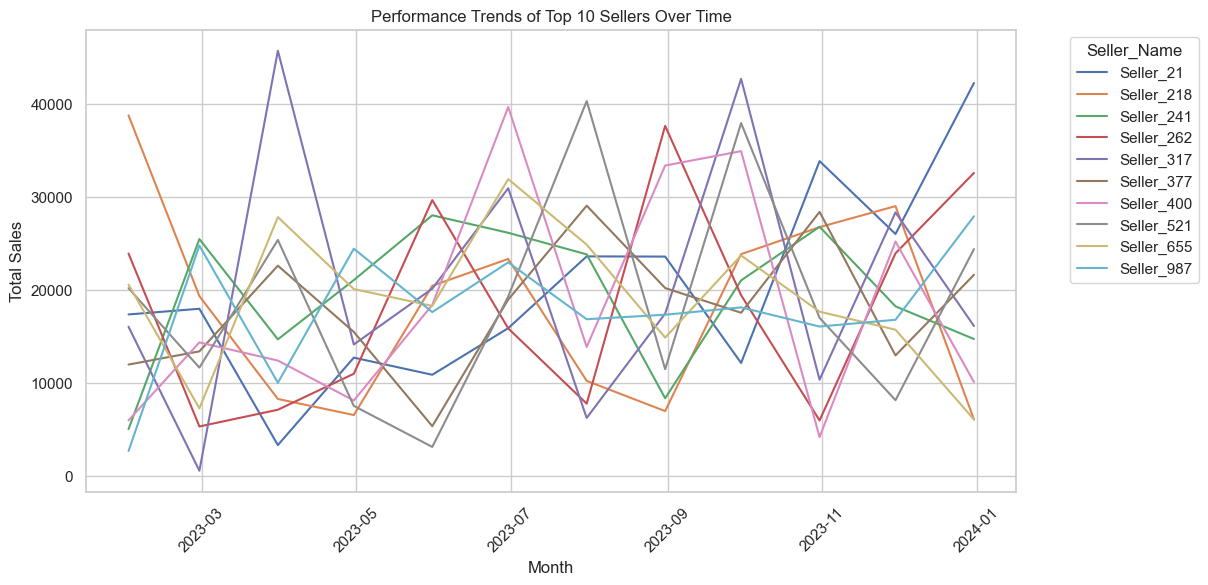

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data if not already loaded
sales_data = pd.read_csv('olap-table/sales_fact.csv')
seller_data = pd.read_csv('olap-table/sellers.csv')

# Ensure Order_Date is in the correct datetime format
sales_data['Order_Date'] = pd.to_datetime(sales_data['Order_Date'])

# Merge sales data with seller data
merged_data = pd.merge(sales_data, seller_data, on='Seller_ID')

# Monthly sales by seller
monthly_sales_by_seller = merged_data.groupby(['Seller_Name', pd.Grouper(key='Order_Date', freq='M')])['Total_Amount'].sum().reset_index()

# Get top 10 sellers by total sales
top_sellers = monthly_sales_by_seller.groupby('Seller_Name')['Total_Amount'].sum().nlargest(10).index
top_monthly_sales_by_seller = monthly_sales_by_seller[monthly_sales_by_seller['Seller_Name'].isin(top_sellers)]

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=top_monthly_sales_by_seller, x='Order_Date', y='Total_Amount', hue='Seller_Name')
plt.title('Performance Trends of Top 10 Sellers Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Seller_Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()


C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


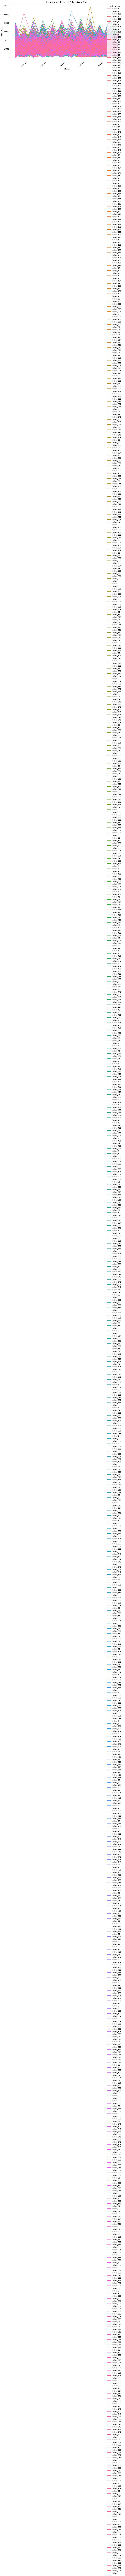

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data if not already loaded
sales_data = pd.read_csv('olap-table/sales_fact.csv')
seller_data = pd.read_csv('olap-table/sellers.csv')

# Ensure Order_Date is in the correct datetime format
sales_data['Order_Date'] = pd.to_datetime(sales_data['Order_Date'])

# Merge sales data with seller data
merged_data = pd.merge(sales_data, seller_data, on='Seller_ID')

# Monthly sales by seller
# Use groupby with a Grouper to handle time resampling at the groupby level
monthly_sales_by_seller = merged_data.groupby(['Seller_Name', pd.Grouper(key='Order_Date', freq='M')])['Total_Amount'].sum().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales_by_seller, x='Order_Date', y='Total_Amount', hue='Seller_Name')
plt.title('Performance Trends of Sellers Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()
